## **Importing necessary libraries and tools**

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('Modules have been loaded')

modules loaded


## **Data Pre-processing**

In [3]:
import os
import pandas as pd

data_dir = '/Users/HP/Desktop/DATA_603_Project/dataset'
filepaths = []
labels = []

# Filter out non-directory items in the dataset directory
folds = [fold for fold in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, fold))]

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        if os.path.isfile(fpath):  # Check if it's a file
            filepaths.append(fpath)
            labels.append(fold)

# Create DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [4]:
df

,filepaths,labels
0,/Users/HP/Desktop/DATA_603_Project/dataset/lig...,lightning
1,/Users/HP/Desktop/DATA_603_Project/dataset/lig...,lightning
2,/Users/HP/Desktop/DATA_603_Project/dataset/lig...,lightning
3,/Users/HP/Desktop/DATA_603_Project/dataset/lig...,lightning
4,/Users/HP/Desktop/DATA_603_Project/dataset/lig...,lightning
...,...,...
6857,/Users/HP/Desktop/DATA_603_Project/dataset/sno...,snow
6858,/Users/HP/Desktop/DATA_603_Project/dataset/sno...,snow
6859,/Users/HP/Desktop/DATA_603_Project/dataset/sno...,snow
6860,/Users/HP/Desktop/DATA_603_Project/dataset/sno...,snow


Splitting the dataframe into train and validation dataset:

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

## **Image generator:**

In [6]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 5489 validated image filenames belonging to 11 classes.
Found 823 validated image filenames belonging to 11 classes.
Found 550 validated image filenames belonging to 11 classes.


Displaying the samples of train data

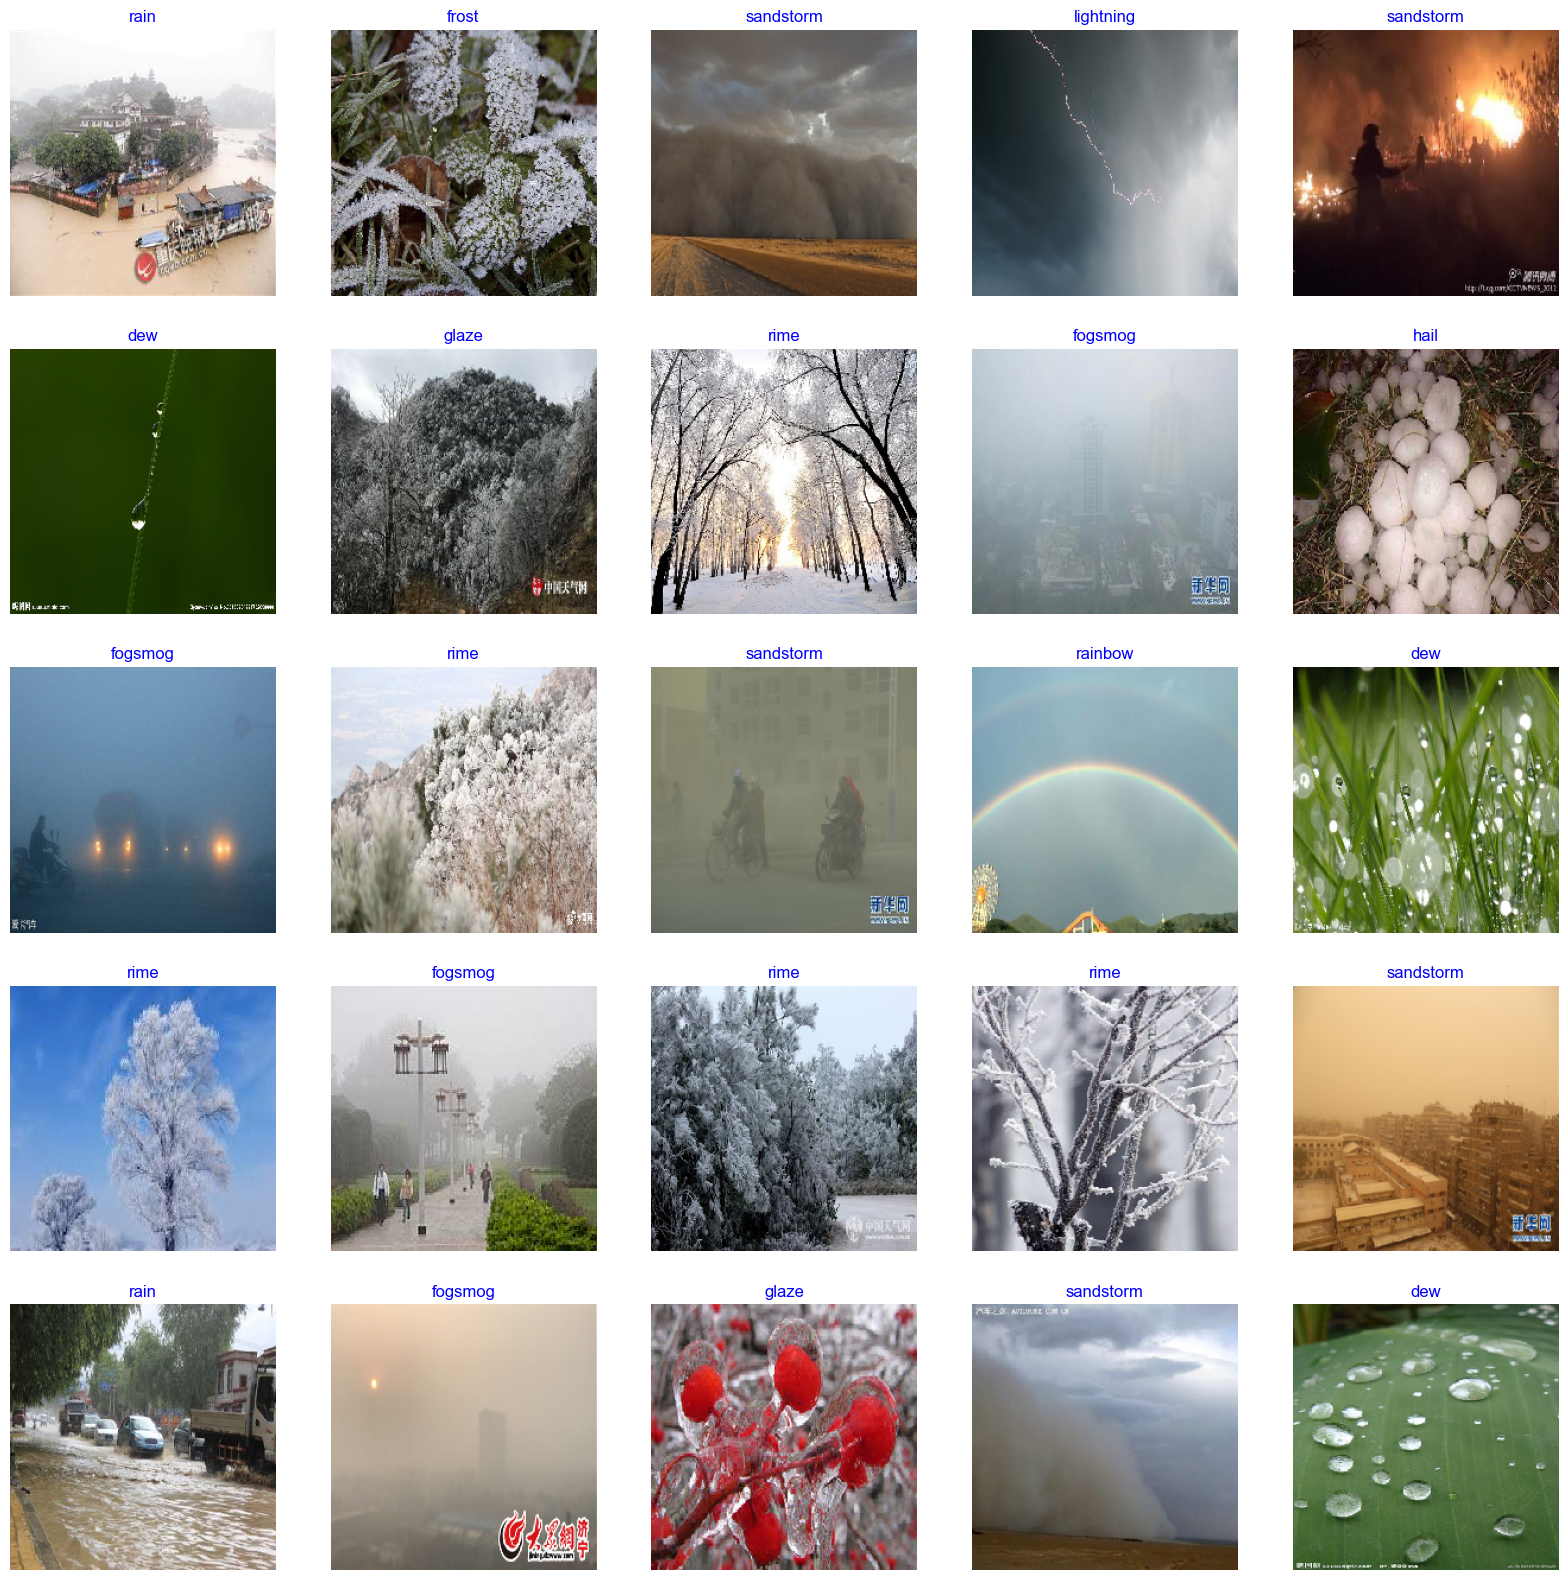

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## **Model Creation:**

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 11

In [10]:
history = model.fit(x= train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

86/86 [==============================] - 1799s 21s/step - loss: 4.9494 - accuracy: 0.9208 - val_loss: 4.2553 - val_accuracy: 0.9210


## **Model Performance:**

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have these metrics for one epoch
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot training history for one epoch
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(tr_loss, 'r', label='Training Loss')
plt.plot(val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss for One Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(tr_acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for One Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


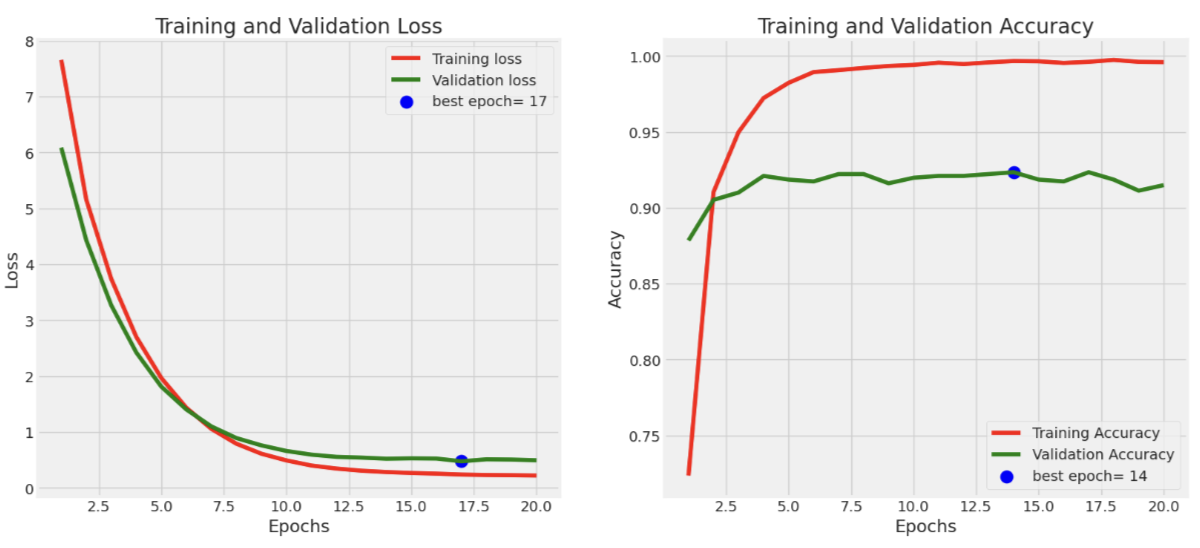

## **Predictions:**

In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

## **Confusion Matrices and Classification reports:**

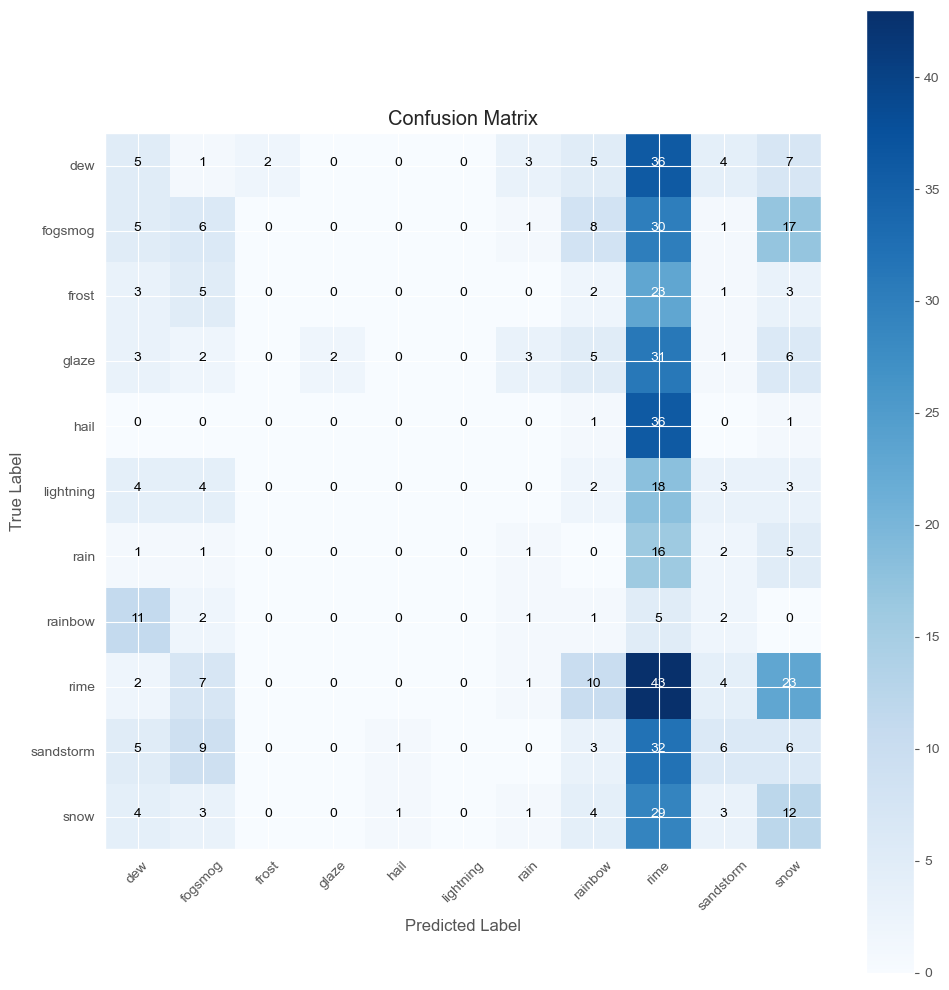

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         dew       0.12      0.08      0.09        63
     fogsmog       0.15      0.09      0.11        68
       frost       0.00      0.00      0.00        37
       glaze       1.00      0.04      0.07        53
        hail       0.00      0.00      0.00        38
   lightning       0.00      0.00      0.00        34
        rain       0.09      0.04      0.05        26
     rainbow       0.02      0.05      0.03        22
        rime       0.14      0.48      0.22        90
   sandstorm       0.22      0.10      0.13        62
        snow       0.14      0.21      0.17        57

    accuracy                           0.14       550
   macro avg       0.17      0.10      0.08       550
weighted avg       0.20      0.14      0.10       550



## **Saving the model:**

In [26]:
#Save the model
model.save('Weather_Image_Recognition.h5')

## **Predictions using the saved model:**

In [27]:
loaded_model = tf.keras.models.load_model('/Users/HP/Desktop/DATA_603_Project/weather_image_recognition_model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [29]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image

def predict_images_in_folder(dataset_path, loaded_model, classes, target_size=(128, 128)):
    predictions_list = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Consider only image files
                image_path = os.path.join(root, file)

                try:
                    # Preprocess the image
                    img = Image.open(image_path)
                    img = img.resize(target_size)  # Resize the image to match the model input shape
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    img_array = tf.expand_dims(img_array, 0)

                    # Make predictions
                    predictions = loaded_model.predict(img_array)
                    score = tf.nn.softmax(predictions[0])

                    predicted_class = classes[tf.argmax(score)]
                    predictions_list.append({"image": file, "predicted_class": predicted_class, "score": float(score[tf.argmax(score)])})

                except Exception as e:
                    print(f"Error processing image {file}: {str(e)}")

    return predictions_list

# Example usage
dataset_path = '/Users/HP/Desktop/DATA_603_Project/test_dataset'
target_size = (128, 128)  # Adjust the target size to match the model input shape
predictions = predict_images_in_folder(dataset_path, loaded_model, classes, target_size)

# Print predictions
for prediction in predictions:
    print(f"Image: {prediction['image']}, Predicted Class: {prediction['predicted_class']}, Score: {prediction['score']:.4f}")


1/1 [==============================] - 0s 7ms/step
Error processing image 4076.jpg: Graph execution error:

Detected at node sequential_1/conv2d_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  Fi

2023-12-10 22:48:37.255804: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 1 vs 3


1/1 [==============================] - 0s 7ms/step
Error processing image 4078.jpg: Graph execution error:

Detected at node sequential_1/conv2d_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  Fi

2023-12-10 22:48:37.617655: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3


1/1 [==============================] - 0s 7ms/step
Error processing image 0593.jpg: Graph execution error:

Detected at node sequential_1/conv2d_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/HP/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/HP/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  Fi

2023-12-10 22:48:39.385482: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3


1/1 [==============================] - 0s 7ms/step
Image: 1838.jpg, Predicted Class: rime, Score: 0.1850
Image: 1839.jpg, Predicted Class: rainbow, Score: 0.2137
Image: 1849.jpg, Predicted Class: rime, Score: 0.2137
Image: 1848.jpg, Predicted Class: rime, Score: 0.2137
Image: 1846.jpg, Predicted Class: rime, Score: 0.2137
Image: 1847.jpg, Predicted Class: frost, Score: 0.2137
Image: 1845.jpg, Predicted Class: rime, Score: 0.2137
Image: 1851.jpg, Predicted Class: rime, Score: 0.2137
Image: 1850.jpg, Predicted Class: hail, Score: 0.2137
Image: 1844.jpg, Predicted Class: rime, Score: 0.2137
Image: 1840.jpg, Predicted Class: hail, Score: 0.2137
Image: 1841.jpg, Predicted Class: dew, Score: 0.2137
Image: 1843.jpg, Predicted Class: rime, Score: 0.2137
Image: 1842.jpg, Predicted Class: rime, Score: 0.2137
Image: 1831.jpg, Predicted Class: dew, Score: 0.2137
Image: 1830.jpg, Predicted Class: rime, Score: 0.2137
Image: 1832.jpg, Predicted Class: glaze, Score: 0.2137
Image: 1833.jpg, Predicted C